In [1]:
import itertools
import matplotlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tqdm import tqdm
from scipy.spatial import distance

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
np.random.seed(0)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

y = np.argmax(y_train, axis=1)
x_train_1s = x_train[np.where(y==1)]
x_train_8s = x_train[np.where(y==8)]
y_train_1s = y[np.where(y==1)]
y_train_8s = y[np.where(y==8)]

x_train_1s_8s = np.concatenate((x_train_1s, x_train_8s))
y_train_1s_8s = np.concatenate((y_train_1s, y_train_8s))

y_train_1s_8s[np.where(y_train_1s_8s==8)] = 0

order = np.random.permutation(len(x_train_1s_8s))

x_train_1s_8s = x_train_1s_8s[order]
y_train_1s_8s = y_train_1s_8s[order]

print(y_train_1s_8s)

y_train_1s_8s = tf.keras.utils.to_categorical(y_train_1s_8s, 2)

x_train_1s_8s_reshape = [x_train_1s_8s[i].reshape((784)) for i in range(len(x_train_1s_8s))]
print(np.array(x_train_1s_8s_reshape).shape)

[0 1 1 ... 0 0 1]
(12593, 784)


In [5]:
n_hidden_neurons = 4
lr = 0.001
epochs = 200
batch_size = 8
limit = 256
alpha = 0.0 # ignore polysemantic term in loss function.

In [6]:
i = tf.keras.layers.Input(shape=(28*28,))
i2 = tf.keras.layers.Input(shape=(2,))
e = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_1')(i)
o = tf.keras.layers.Dense(2, activation='softmax', name='softmax')(e)
model = tf.keras.Model(inputs=[i, i2], outputs=o)

2022-05-12 19:24:28.780770: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def calculate_term(e, c0, c1):
  a = K.expand_dims(e[c0] / (K.max(K.abs(e[c0])) + 1e-9))
  b = K.expand_dims(e[c1] / (K.max(K.abs(e[c1])) + 1e-9))
  if c0==c1:
    return 0
  else:
    return K.dot(a, K.transpose(b))

In [8]:
#https://stackoverflow.com/questions/62454500/how-to-use-tensorflow-custom-loss-for-a-keras-model
def my_loss(y_true, y_pred, e, c0, c1, alpha):
    p_loss = 0
    for i in range(len(c0)):
      p_loss += calculate_term(e, c0[i], c1[i])

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true=y_true, 
                                                                      y_pred=y_pred)
    loss += alpha * (p_loss / len(c0))
    return loss

In [9]:
c0, c1 = [], []
for c in list(itertools.combinations(range(batch_size), 2)):
    c0.append(c[0])
    c1.append(c[1])

In [10]:
print(len(c0))

28


In [11]:
model.add_loss(my_loss(i2, o, e, np.array(c0, dtype='int32'), np.array(c1, dtype='int32'), alpha))

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss=None)

In [13]:
model.fit([np.array(x_train_1s_8s_reshape)[:limit], y_train_1s_8s[:limit]],
          y=None,
          batch_size=batch_size,
          epochs=epochs)

2022-05-12 19:24:30.829114: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
32/32 [==============================] - 5s 2ms/step - loss: 0.6405
Epoch 2/200
32/32 [==============================] - 0s 2ms/step - loss: 0.5149
Epoch 3/200
32/32 [==============================] - 0s 2ms/step - loss: 0.3640
Epoch 4/200
32/32 [==============================] - 0s 2ms/step - loss: 0.2036
Epoch 5/200
32/32 [==============================] - 0s 2ms/step - loss: 0.1441
Epoch 6/200
32/32 [==============================] - 0s 2ms/step - loss: 0.1161
Epoch 7/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0997
Epoch 8/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0845
Epoch 9/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0746
Epoch 10/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0664
Epoch 11/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0602
Epoch 12/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0542
Epoch 13/200
32/32 [=================

32/32 [==============================] - 0s 2ms/step - loss: 6.9584e-04
Epoch 102/200
32/32 [==============================] - 0s 2ms/step - loss: 6.7725e-04
Epoch 103/200
32/32 [==============================] - 0s 2ms/step - loss: 6.5635e-04
Epoch 104/200
32/32 [==============================] - 0s 2ms/step - loss: 6.4138e-04
Epoch 105/200
32/32 [==============================] - 0s 2ms/step - loss: 6.2893e-04
Epoch 106/200
32/32 [==============================] - 0s 2ms/step - loss: 6.0462e-04
Epoch 107/200
32/32 [==============================] - 0s 2ms/step - loss: 5.8585e-04
Epoch 108/200
32/32 [==============================] - 0s 2ms/step - loss: 5.7509e-04
Epoch 109/200
32/32 [==============================] - 0s 2ms/step - loss: 5.6066e-04
Epoch 110/200
32/32 [==============================] - 0s 2ms/step - loss: 5.4202e-04
Epoch 111/200
32/32 [==============================] - 0s 2ms/step - loss: 5.2935e-04
Epoch 112/200
32/32 [==============================] - 0s 2ms/step -

32/32 [==============================] - 0s 2ms/step - loss: 8.0991e-05
Epoch 197/200
32/32 [==============================] - 0s 2ms/step - loss: 7.8854e-05
Epoch 198/200
32/32 [==============================] - 0s 2ms/step - loss: 7.7661e-05
Epoch 199/200
32/32 [==============================] - 0s 2ms/step - loss: 7.6402e-05
Epoch 200/200
32/32 [==============================] - 0s 2ms/step - loss: 7.5639e-05


In [14]:
embed = tf.keras.Model(inputs=i, outputs=e)

In [15]:
embed.layers[1].set_weights(model.layers[1].get_weights())
activations_by_class = {}
for i in tqdm(range(len(x_train_1s_8s_reshape[:limit]))):
    a = embed.predict(np.array(x_train_1s_8s_reshape[i][np.newaxis]))
    try:
        activations_by_class[np.argmax(y_train_1s_8s, axis=1)[i]] += np.squeeze(a)
    except KeyError:
        activations_by_class[np.argmax(y_train_1s_8s, axis=1)[i]] = np.squeeze(a)

100%|█████████████████████████████████████████████████████████████████████████| 256/256 [00:09<00:00, 27.12it/s]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


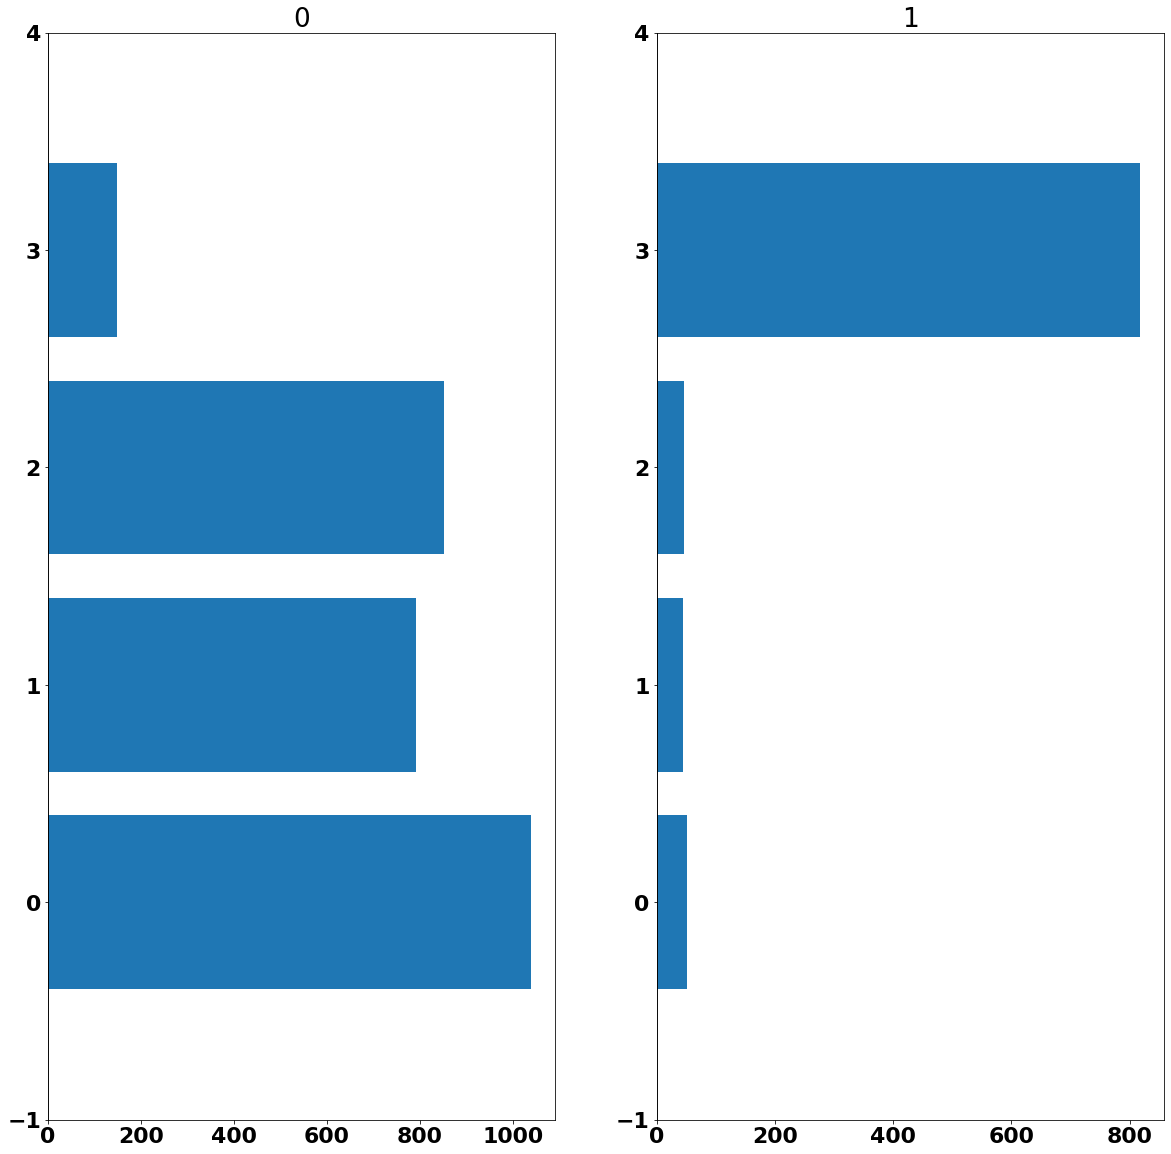

In [16]:
fig = plt.figure(figsize=(20,20))
for i,k in enumerate(activations_by_class.keys()):
    y_pos = np.arange(len(activations_by_class[k]))
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.squeeze(activations_by_class[k]), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(activations_by_class[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(activations_by_class[k])))

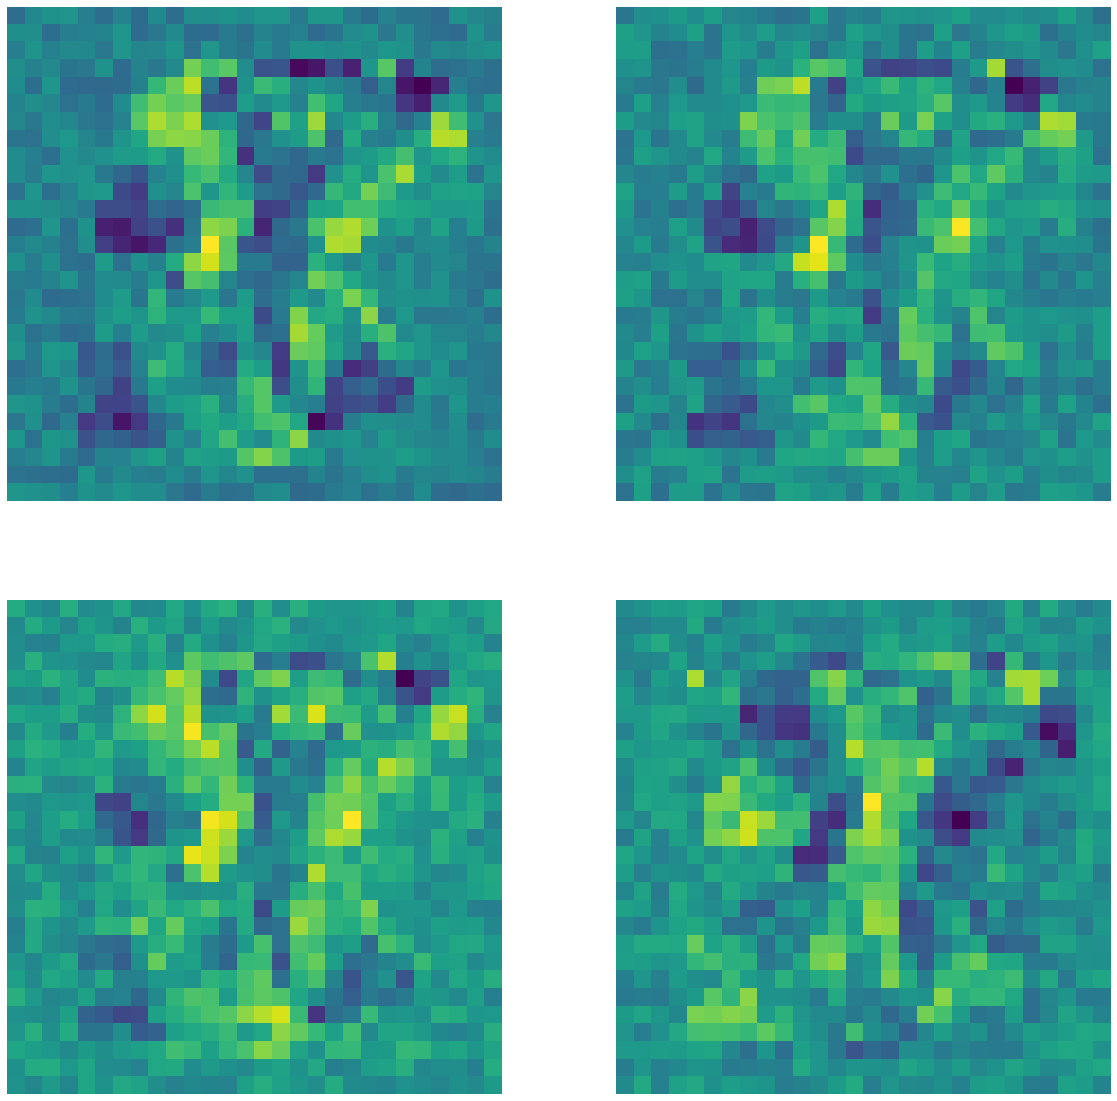

In [17]:
W = embed.layers[1].get_weights()
fig = plt.figure(figsize=(20,20))
dim = int(np.ceil(np.sqrt(n_hidden_neurons)))
for j in range(n_hidden_neurons):
  x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
  ax = fig.add_subplot(dim,dim,j+1)
  ax.imshow(x_j.reshape((28,28)))
  plt.axis('off')
plt.show()